# Nuestro modelo con búsqueda exhaustiva para selección de parámetros

In [ ]:
!pip uninstall xgboost

In [ ]:
!pip install -U xgboost

In [14]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
print("Esta ejecutando")
class RandomForest:
    def __init__(self, n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf, 
                 max_features, bootstrap, learning_rate, subsample, colsample_bytree, num_leaves, gamma,
                 objective='binary:logistic', max_leaf_nodes=None, min_impurity_decrease=0.0,
                 min_weight_fraction_leaf=0.0, min_child_samples=20, feature_fraction=0.6,  metric='logloss'):
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.random_state = 42
        self.stacking_model = None  
        self.predictions = []
        self.learning_rate = learning_rate  
        self.subsample = subsample  
        self.colsample_bytree = colsample_bytree  
        self.num_leaves = num_leaves
        self.gamma = gamma
        self.objective = objective
        self.max_leaf_nodes = max_leaf_nodes
        self.min_impurity_decrease = min_impurity_decrease
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.min_child_samples = min_child_samples
        self.feature_fraction = feature_fraction
        self.metric = metric

    def fit(self, X, y):        
        n_estimators_per_model = self.n_estimators // 3
        # Definir el clasificador de nivel 1
        estimators = [
            ('xgb', XGBClassifier(n_estimators=n_estimators_per_model, max_depth=self.max_depth, random_state=self.random_state,
                                  learning_rate=self.learning_rate, subsample=self.subsample, colsample_bytree=self.colsample_bytree,
                                  gamma=self.gamma, objective=self.objective, max_leaf_nodes=self.max_leaf_nodes,
                                  min_impurity_decrease=self.min_impurity_decrease, min_weight_fraction_leaf=self.min_weight_fraction_leaf,
                                  min_child_samples=self.min_child_samples, feature_fraction=self.feature_fraction,metric=self.metric)),
            ('lgbm', LGBMClassifier(n_estimators=n_estimators_per_model, max_depth=self.max_depth, random_state=self.random_state,
                                    learning_rate=self.learning_rate, subsample=self.subsample, colsample_bytree=self.colsample_bytree,
                                    num_leaves=self.num_leaves, max_leaf_nodes=self.max_leaf_nodes,
                                    min_child_samples=self.min_child_samples, feature_fraction=self.feature_fraction)),
            ('extra_trees', ExtraTreesClassifier(n_estimators=n_estimators_per_model, criterion=self.criterion,
                                                 max_depth=self.max_depth, min_samples_split=self.min_samples_split,
                                                 min_samples_leaf=self.min_samples_leaf, max_features=self.max_features,
                                                 bootstrap=self.bootstrap, random_state=self.random_state))]
            
        # Definir el clasificador de nivel 2 (modelo base)
        rf_base = RandomForestClassifier(n_estimators=self.n_estimators, random_state=self.random_state)
        
        # Crear el modelo de stacking
        self.stacking_model = StackingClassifier(estimators=estimators, final_estimator=rf_base)
        self.stacking_model.fit(X, y)

    def predict(self, X):
        return self.stacking_model.predict(X)
    def get_params(self, deep=True):
        return {
            'n_estimators': self.n_estimators,
            'criterion': self.criterion,
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
            'min_samples_leaf': self.min_samples_leaf,
            'max_features': self.max_features,
            'bootstrap': self.bootstrap,
            'learning_rate': self.learning_rate,
            'subsample': self.subsample,
            'colsample_bytree': self.colsample_bytree,
            'num_leaves': self.num_leaves,
            'gamma': self.gamma,
            'objective': self.objective,
            'max_leaf_nodes': self.max_leaf_nodes,
            'min_impurity_decrease': self.min_impurity_decrease,
            'min_weight_fraction_leaf': self.min_weight_fraction_leaf,
            'min_child_samples': self.min_child_samples,
            'feature_fraction': self.feature_fraction,
            'metric': self.metric
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

class RandomForestClassifierWrapper:
    def __init__(self, X, y, n_estimators, criterion, max_depth, min_samples_split,
                 min_samples_leaf, max_features, bootstrap, learning_rate, subsample, colsample_bytree, num_leaves, gamma,
                 objective='binary', max_leaf_nodes=None, min_impurity_decrease=0.0,
                 min_weight_fraction_leaf=0.0, min_child_samples=20, feature_fraction=0.6):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        self.X_train = self.X_train.values
        self.y_train = self.y_train.values
        
        self.rf = RandomForest(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth,
                                min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                max_features=max_features, bootstrap=bootstrap,
                                learning_rate=learning_rate, subsample=subsample,
                                colsample_bytree=colsample_bytree, num_leaves=num_leaves, gamma=gamma,
                                objective=objective, max_leaf_nodes=max_leaf_nodes,
                                min_impurity_decrease=min_impurity_decrease, min_weight_fraction_leaf=min_weight_fraction_leaf,
                                min_child_samples=min_child_samples, feature_fraction=feature_fraction)
        self.estimators = []

    def train(self):
        self.rf.fit(self.X_train, self.y_train)
        
    def predict(self):
        return self.rf.predict(self.X_test)

    def evaluate(self):
        y_pred = self.predict()        
        accuracy = accuracy_score(self.y_test, y_pred)
        precision = precision_score(self.y_test, y_pred, average='macro')
        recall = recall_score(self.y_test, y_pred, average='macro')
        f1 = f1_score(self.y_test, y_pred, average='macro')
        return accuracy, precision, recall, f1

import os
# Obtener la ruta del directorio actual
ruta_actual = os.getcwd()
# Concatenar el nombre del archivo al final de la ruta actual
archivo = os.path.join(ruta_actual, 'Balanced_Data_Set.xlsx')
# Cargar datos
df = pd.read_excel(archivo)
# Leer datos
#df = pd.read_excel("C:\\Users\\klgt1\\Downloads\\dataset_BALANCEADO.xlsx")
X = df.drop('CONDUCTA', axis=1)
y = df['CONDUCTA']


print("Esta ejecutando")
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [20,50],
    'criterion': ['entropy'],
    'max_depth': [5,20],
    'min_samples_split': [2,4],
    'min_samples_leaf': [1],
    'max_features': ['sqrt','log2'],
    'bootstrap': [True],
    'learning_rate': [0.001,0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'num_leaves': [40],
    'gamma': [0],
    'metric':['logloss'], #FALTA
    'objective':['binary:logistic'],
    'min_impurity_decrease': [0.1],
    'min_weight_fraction_leaf': [0.0],
    'min_child_samples': [10],
    'feature_fraction': [0.6],
}
# Crear instancia del clasificador
rf_wrapper = RandomForestClassifierWrapper(X, y, n_estimators=50, criterion='entropy', max_depth=20, min_samples_split=4,
                                           min_samples_leaf=1, max_features=0.25, bootstrap=True, learning_rate=0.1,
                                           subsample=0.8, colsample_bytree=1.0, num_leaves=31, gamma=1,
                                           objective='binary:logistic')


# Entrenar el modelo
rf_wrapper.train()

# Crear instancia de GridSearchCV
grid_search = GridSearchCV(rf_wrapper.rf, param_grid=param_grid, cv=5, scoring='precision', verbose=2, n_jobs=-1)

# Entrenar el modelo
grid_search.fit(rf_wrapper.X_train, rf_wrapper.y_train)


# Imprimir resultados
print("Mejores hiperparámetros:")
print(grid_search.best_params_)
print("Mejor score: ", grid_search.best_score_)


Esta ejecutando
Esta ejecutando
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 906, number of negative: 1115
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 559
[LightGBM] [Info] Number of data points in the train set: 2021, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448293 -> initscore=-0.207570
[LightGBM] [Info] Start t

C:\Users\klgt1\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [20:50:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "feature_fraction", "metric", "min_child_samples", "min_impurity_decrease", "min_weight_fraction_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\klgt1\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [20:50:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "feature_fraction", "metric", "min_child_samples", "min_impurity_decrease", "min_weight_fraction_leaf" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 725, number of negative: 892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM

C:\Users\klgt1\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [20:51:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "feature_fraction", "metric", "min_child_samples", "min_impurity_decrease", "min_weight_fraction_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\klgt1\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [20:51:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "feature_fraction", "metric", "min_child_samples", "min_impurity_decrease", "min_weight_fraction_leaf" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Info] Number of positive: 906, number of negative: 1115
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 559
[LightGBM] [Info] Number of data points in the train set: 2021, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448293 -> initscore=-0.207570
[LightGBM] [Info] Start training from score -0.207570
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Inf

In [1]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
print("Esta ejecutando")
class RandomForest:
    def __init__(self, n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf, 
                 max_features, bootstrap, learning_rate, subsample, colsample_bytree, num_leaves, gamma,
                 objective='binary:logistic', max_leaf_nodes=None, min_impurity_decrease=0.0,
                 min_weight_fraction_leaf=0.0, min_child_samples=20, feature_fraction=0.6,  metric='logloss'):
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.random_state = 42
        self.stacking_model = None  
        self.predictions = []
        self.learning_rate = learning_rate  
        self.subsample = subsample  
        self.colsample_bytree = colsample_bytree  
        self.num_leaves = num_leaves
        self.gamma = gamma
        self.objective = objective
        self.max_leaf_nodes = max_leaf_nodes
        self.min_impurity_decrease = min_impurity_decrease
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.min_child_samples = min_child_samples
        self.feature_fraction = feature_fraction
        self.metric = metric

    def fit(self, X, y):        
        # Definir el clasificador de nivel 1
        estimators = [
            ('xgb', XGBClassifier(n_estimators=self.n_estimators, max_depth=self.max_depth, random_state=self.random_state,
                                  learning_rate=self.learning_rate, subsample=self.subsample, colsample_bytree=self.colsample_bytree,
                                  gamma=self.gamma, objective=self.objective, max_leaf_nodes=self.max_leaf_nodes,
                                  min_impurity_decrease=self.min_impurity_decrease, min_weight_fraction_leaf=self.min_weight_fraction_leaf,
                                  min_child_samples=self.min_child_samples, feature_fraction=self.feature_fraction,metric=self.metric)),
            ('lgbm', LGBMClassifier(n_estimators=self.n_estimators, max_depth=self.max_depth, random_state=self.random_state,
                                    learning_rate=self.learning_rate, subsample=self.subsample, colsample_bytree=self.colsample_bytree,
                                    num_leaves=self.num_leaves, max_leaf_nodes=self.max_leaf_nodes,
                                    min_child_samples=self.min_child_samples, feature_fraction=self.feature_fraction)),
            ('extra_trees', ExtraTreesClassifier(n_estimators=self.n_estimators, criterion=self.criterion,
                                                 max_depth=self.max_depth, min_samples_split=self.min_samples_split,
                                                 min_samples_leaf=self.min_samples_leaf, max_features=self.max_features,
                                                 bootstrap=self.bootstrap, random_state=self.random_state))]
            
        # Definir el clasificador de nivel 2 (modelo base)
        rf_base = RandomForestClassifier(n_estimators=self.n_estimators, random_state=self.random_state)
        
        # Crear el modelo de stacking
        self.stacking_model = StackingClassifier(estimators=estimators, final_estimator=rf_base)
        self.stacking_model.fit(X, y)

    def predict(self, X):
        return self.stacking_model.predict(X)
    def get_params(self, deep=True):
        return {
            'n_estimators': self.n_estimators,
            'criterion': self.criterion,
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
            'min_samples_leaf': self.min_samples_leaf,
            'max_features': self.max_features,
            'bootstrap': self.bootstrap,
            'learning_rate': self.learning_rate,
            'subsample': self.subsample,
            'colsample_bytree': self.colsample_bytree,
            'num_leaves': self.num_leaves,
            'gamma': self.gamma,
            'objective': self.objective,
            'max_leaf_nodes': self.max_leaf_nodes,
            'min_impurity_decrease': self.min_impurity_decrease,
            'min_weight_fraction_leaf': self.min_weight_fraction_leaf,
            'min_child_samples': self.min_child_samples,
            'feature_fraction': self.feature_fraction,
            'metric': self.metric
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

class RandomForestClassifierWrapper:
    def __init__(self, X, y, n_estimators, criterion, max_depth, min_samples_split,
                 min_samples_leaf, max_features, bootstrap, learning_rate, subsample, colsample_bytree, num_leaves, gamma,
                 objective='binary', max_leaf_nodes=None, min_impurity_decrease=0.0,
                 min_weight_fraction_leaf=0.0, min_child_samples=20, feature_fraction=0.6):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        self.X_train = self.X_train.values
        self.y_train = self.y_train.values
        
        self.rf = RandomForest(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth,
                                min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                max_features=max_features, bootstrap=bootstrap,
                                learning_rate=learning_rate, subsample=subsample,
                                colsample_bytree=colsample_bytree, num_leaves=num_leaves, gamma=gamma,
                                objective=objective, max_leaf_nodes=max_leaf_nodes,
                                min_impurity_decrease=min_impurity_decrease, min_weight_fraction_leaf=min_weight_fraction_leaf,
                                min_child_samples=min_child_samples, feature_fraction=feature_fraction)
        self.estimators = []

    def train(self):
        self.rf.fit(self.X_train, self.y_train)
        
    def predict(self):
        return self.rf.predict(self.X_test)

    def evaluate(self):
        y_pred = self.predict()        
        accuracy = accuracy_score(self.y_test, y_pred)
        precision = precision_score(self.y_test, y_pred, average='macro')
        recall = recall_score(self.y_test, y_pred, average='macro')
        f1 = f1_score(self.y_test, y_pred, average='macro')
        return accuracy, precision, recall, f1

import os
# Obtener la ruta del directorio actual
ruta_actual = os.getcwd()
# Concatenar el nombre del archivo al final de la ruta actual
archivo = os.path.join(ruta_actual, 'Balanced_Data_Set.xlsx')
# Cargar datos
df = pd.read_excel(archivo)
# Leer datos
#df = pd.read_excel("C:\\Users\\klgt1\\Downloads\\dataset_BALANCEADO.xlsx")
X = df.drop('CONDUCTA', axis=1)
y = df['CONDUCTA']


print("Esta ejecutando")
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [20,50],
    'criterion': ['entropy'],
    'max_depth': [5,20],
    'min_samples_split': [2,4],
    'min_samples_leaf': [1],
    'max_features': ['sqrt','log2'],
    'bootstrap': [True],
    'learning_rate': [0.001,0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'num_leaves': [40],
    'gamma': [0],
    'metric':['logloss'], #FALTA
    'objective':['binary:logistic'],
    'min_impurity_decrease': [0.1],
    'min_weight_fraction_leaf': [0.0],
    'min_child_samples': [10],
    'feature_fraction': [0.6],
}
# Crear instancia del clasificador
rf_wrapper = RandomForestClassifierWrapper(X, y, n_estimators=50, criterion='entropy', max_depth=20, min_samples_split=4,
                                           min_samples_leaf=1, max_features=0.25, bootstrap=True, learning_rate=0.1,
                                           subsample=0.8, colsample_bytree=1.0, num_leaves=31, gamma=1,
                                           objective='binary:logistic')


# Entrenar el modelo
rf_wrapper.train()

# Crear instancia de GridSearchCV
grid_search = GridSearchCV(rf_wrapper.rf, param_grid=param_grid, cv=5, scoring='precision', verbose=2, n_jobs=-1)

# Entrenar el modelo
grid_search.fit(rf_wrapper.X_train, rf_wrapper.y_train)

# Imprimir resultados
print("Mejores hiperparámetros:")
print(grid_search.best_params_)
print("Mejor score: ", grid_search.best_score_)


Esta ejecutando
Esta ejecutando
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 906, number of negative: 1115
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 559
[LightGBM] [Info] Number of data points in the train set: 2021, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]

C:\Users\klgt1\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:23:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "feature_fraction", "metric", "min_child_samples", "min_impurity_decrease", "min_weight_fraction_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\klgt1\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\klgt1\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueEr

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 724, number of negative: 892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 1616, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448020 -> initscore=-0.208675
[LightGBM] [Info] Start training from score -0.208675
[Lig

C:\Users\klgt1\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:24:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "feature_fraction", "metric", "min_child_samples", "min_impurity_decrease", "min_weight_fraction_leaf" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Info] Number of positive: 906, number of negative: 1115
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 559
[LightGBM] [Info] Number of data points in the train set: 2021, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448293 -> initscore=-0.207570
[LightGBM] [Info] Start training from score -0.207570


C:\Users\klgt1\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:24:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "feature_fraction", "metric", "min_child_samples", "min_impurity_decrease", "min_weight_fraction_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\klgt1\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:24:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "feature_fraction", "metric", "min_child_samples", "min_impurity_decrease", "min_weight_fraction_leaf" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Info] Number of positive: 724, number of negative: 892
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 1616, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448020 -> initscore=-0.208675
[LightGBM] [Info] Start training from score -0.208675
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.8 will 

Esta ejecutando
Esta ejecutando
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 906, number of negative: 1115
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 559
[LightGBM] [Info] Number of data points in the train set: 2021, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]

C:\Users\klgt1\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:30:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "feature_fraction", "metric", "min_child_samples", "min_impurity_decrease", "min_weight_fraction_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\klgt1\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:30:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "feature_fraction", "metric", "min_child_samples", "min_impurity_decrease", "min_weight_fraction_leaf" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 724, number of negative: 892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 1616, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448020 -> initscore=-0.208675
[LightGBM] [Info] Start training from score -0.208675
[Lig

C:\Users\klgt1\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:31:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "feature_fraction", "metric", "min_child_samples", "min_impurity_decrease", "min_weight_fraction_leaf" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Info] Number of positive: 906, number of negative: 1115
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 559
[LightGBM] [Info] Number of data points in the train set: 2021, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448293 -> initscore=-0.207570
[LightGBM] [Info] Start training from score -0.207570


C:\Users\klgt1\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:31:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "feature_fraction", "metric", "min_child_samples", "min_impurity_decrease", "min_weight_fraction_leaf" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Info] Number of positive: 724, number of negative: 892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 1616, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448020 -> initscore=-0.208675
[LightGBM] [Info] Start training from score -0.208675
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warn

C:\Users\klgt1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(


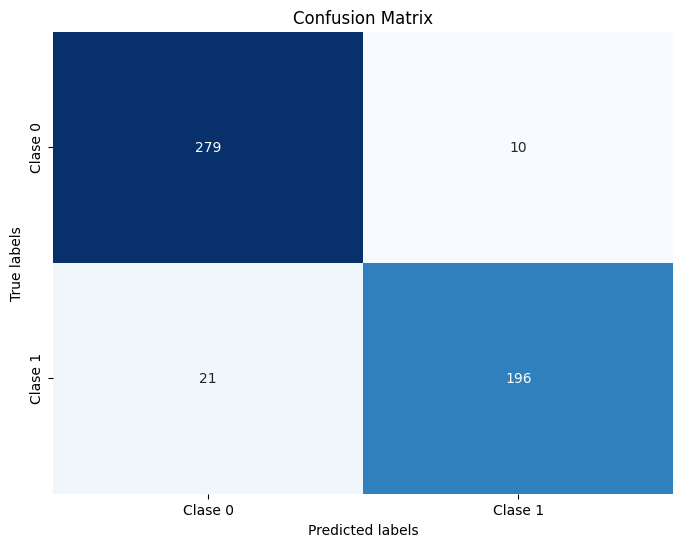


Precisión del modelo: 94.07%
Exactitud del modelo: 93.87%
Recall del modelo: 93.43%
F1-score del modelo: 93.70%



In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
print("Esta ejecutando")
class RandomForest:
    def __init__(self, n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf, 
                 max_features, bootstrap, learning_rate, subsample, colsample_bytree, num_leaves, gamma,
                 objective='binary:logistic', max_leaf_nodes=None, min_impurity_decrease=0.0,
                 min_weight_fraction_leaf=0.0, min_child_samples=20, feature_fraction=0.6,  metric='logloss'):
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.random_state = 42
        self.stacking_model = None  
        self.predictions = []
        self.learning_rate = learning_rate  
        self.subsample = subsample  
        self.colsample_bytree = colsample_bytree  
        self.num_leaves = num_leaves
        self.gamma = gamma
        self.objective = objective
        self.max_leaf_nodes = max_leaf_nodes
        self.min_impurity_decrease = min_impurity_decrease
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.min_child_samples = min_child_samples
        self.feature_fraction = feature_fraction
        self.metric = metric

    def fit(self, X, y):        
        # Definir el clasificador de nivel 1
        estimators = [
            ('xgb', XGBClassifier(n_estimators=self.n_estimators, max_depth=self.max_depth, random_state=self.random_state,
                                  learning_rate=self.learning_rate, subsample=self.subsample, colsample_bytree=self.colsample_bytree,
                                  gamma=self.gamma, objective=self.objective, max_leaf_nodes=self.max_leaf_nodes,
                                  min_impurity_decrease=self.min_impurity_decrease, min_weight_fraction_leaf=self.min_weight_fraction_leaf,
                                  min_child_samples=self.min_child_samples, feature_fraction=self.feature_fraction,metric=self.metric)),
            ('lgbm', LGBMClassifier(n_estimators=self.n_estimators, max_depth=self.max_depth, random_state=self.random_state,
                                    learning_rate=self.learning_rate, subsample=self.subsample, colsample_bytree=self.colsample_bytree,
                                    num_leaves=self.num_leaves, max_leaf_nodes=self.max_leaf_nodes,
                                    min_child_samples=self.min_child_samples, feature_fraction=self.feature_fraction)),
            ('extra_trees', ExtraTreesClassifier(n_estimators=self.n_estimators, criterion=self.criterion,
                                                 max_depth=self.max_depth, min_samples_split=self.min_samples_split,
                                                 min_samples_leaf=self.min_samples_leaf, max_features=self.max_features,
                                                 bootstrap=self.bootstrap, random_state=self.random_state))]
            
        # Definir el clasificador de nivel 2 (modelo base)
        rf_base = RandomForestClassifier(n_estimators=self.n_estimators, criterion=self.criterion,max_depth=self.max_depth,
                                         min_samples_split=self.min_samples_split,min_samples_leaf=self.min_samples_leaf,
                                         max_features=self.max_features,bootstrap=self.bootstrap, random_state=self.random_state)
        
        # Crear el modelo de stacking
        self.stacking_model = StackingClassifier(estimators=estimators, final_estimator=rf_base)
        self.stacking_model.fit(X, y)

    def predict(self, X):
        return self.stacking_model.predict(X)
    def get_params(self, deep=True):
        return {
            'n_estimators': self.n_estimators,
            'criterion': self.criterion,
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
            'min_samples_leaf': self.min_samples_leaf,
            'max_features': self.max_features,
            'bootstrap': self.bootstrap,
            'learning_rate': self.learning_rate,
            'subsample': self.subsample,
            'colsample_bytree': self.colsample_bytree,
            'num_leaves': self.num_leaves,
            'gamma': self.gamma,
            'objective': self.objective,
            'max_leaf_nodes': self.max_leaf_nodes,
            'min_impurity_decrease': self.min_impurity_decrease,
            'min_weight_fraction_leaf': self.min_weight_fraction_leaf,
            'min_child_samples': self.min_child_samples,
            'feature_fraction': self.feature_fraction,
            'metric': self.metric
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

class RandomForestClassifierWrapper:
    def __init__(self, X, y, n_estimators, criterion, max_depth, min_samples_split,
                 min_samples_leaf, max_features, bootstrap, learning_rate, subsample, colsample_bytree, num_leaves, gamma,
                 objective='binary', max_leaf_nodes=None, min_impurity_decrease=0.0,
                 min_weight_fraction_leaf=0.0, min_child_samples=20, feature_fraction=0.6):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        self.X_train = self.X_train.values
        self.y_train = self.y_train.values
        
        self.rf = RandomForest(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth,
                                min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                max_features=max_features, bootstrap=bootstrap,
                                learning_rate=learning_rate, subsample=subsample,
                                colsample_bytree=colsample_bytree, num_leaves=num_leaves, gamma=gamma,
                                objective=objective, max_leaf_nodes=max_leaf_nodes,
                                min_impurity_decrease=min_impurity_decrease, min_weight_fraction_leaf=min_weight_fraction_leaf,
                                min_child_samples=min_child_samples, feature_fraction=feature_fraction)
        self.estimators = []

    def train(self):
        self.rf.fit(self.X_train, self.y_train)
        
    def predict(self):
        return self.rf.predict(self.X_test)

    def evaluate(self):
        y_pred = self.predict()        
        accuracy = accuracy_score(self.y_test, y_pred)
        precision = precision_score(self.y_test, y_pred, average='macro')
        recall = recall_score(self.y_test, y_pred, average='macro')
        f1 = f1_score(self.y_test, y_pred, average='macro')
        return accuracy, precision, recall, f1

import os
# Obtener la ruta del directorio actual
ruta_actual = os.getcwd()
# Concatenar el nombre del archivo al final de la ruta actual
archivo = os.path.join(ruta_actual, 'Balanced_Data_Set.xlsx')
# Cargar datos
df = pd.read_excel(archivo)
# Leer datos
#df = pd.read_excel("C:\\Users\\klgt1\\Downloads\\dataset_BALANCEADO.xlsx")
X = df.drop('CONDUCTA', axis=1)
y = df['CONDUCTA']


print("Esta ejecutando")
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [20,50],
    'criterion': ['entropy'],
    'max_depth': [5,20],
    'min_samples_split': [2,4],
    'min_samples_leaf': [1],
    'max_features': ['sqrt','log2'],
    'bootstrap': [True],
    'learning_rate': [0.001,0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'num_leaves': [40],
    'gamma': [0],
    'metric':['logloss'], #FALTA
    'objective':['binary:logistic'],
    'min_impurity_decrease': [0.1],
    'min_weight_fraction_leaf': [0.0],
    'min_child_samples': [10],
    'feature_fraction': [0.6],
}
# Crear instancia del clasificador
rf_wrapper = RandomForestClassifierWrapper(X, y, n_estimators=50, criterion='entropy', max_depth=20, min_samples_split=4,
                                           min_samples_leaf=1, max_features=0.25, bootstrap=True, learning_rate=0.1,
                                           subsample=0.8, colsample_bytree=1.0, num_leaves=31, gamma=1,
                                           objective='binary:logistic')


# Entrenar el modelo
rf_wrapper.train()

# Crear instancia de GridSearchCV
grid_search = GridSearchCV(rf_wrapper.rf, param_grid=param_grid, cv=5, scoring='precision', verbose=2, n_jobs=-1)

# Entrenar el modelo
grid_search.fit(rf_wrapper.X_train, rf_wrapper.y_train)
# Imprimir resultados
print("Mejores hiperparámetros:")
print(grid_search.best_params_)
print("Mejor score: ", grid_search.best_score_)


# Obtener predicciones en el conjunto de prueba
y_pred_test = grid_search.predict(rf_wrapper.X_test)

# Calcular matriz de confusión
conf_matrix = confusion_matrix(rf_wrapper.y_test, y_pred_test)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", cbar=False,
            xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Calcular métricas
accuracy = accuracy_score(rf_wrapper.y_test, y_pred_test)
precision = precision_score(rf_wrapper.y_test, y_pred_test, average='macro')
recall = recall_score(rf_wrapper.y_test, y_pred_test, average='macro')
f1 = f1_score(rf_wrapper.y_test, y_pred_test, average='macro')

# Mostrar métricas
print(f'\nPrecisión del modelo: {precision * 100:.2f}%')
print(f'Exactitud del modelo: {accuracy * 100:.2f}%')
print(f'Recall del modelo: {recall * 100:.2f}%')
print(f'F1-score del modelo: {f1 * 100:.2f}%\n')